# Báo cáo phân tích biến động giá cổ phiếu 
## 🎯 Mục tiêu
Mục tiêu của bài phân tích này là:

- Đánh giá **xu hướng biến động giá cổ phiếu** trong ít nhất một năm gần nhất.
- Tính toán và trực quan hóa các **chỉ số kỹ thuật cơ bản** như SMA, EMA, Volatility để hỗ trợ phân tích.
- Xác định các **giai đoạn biến động mạnh** và **mô hình xu hướng** nhằm tìm ra **thời điểm đầu tư hợp lý**.
- Rút ra **nhận định và khuyến nghị cơ bản** về việc mua, nắm giữ hoặc bán cổ phiếu dựa trên dữ liệu thực tế.

## 📥 1. Chọn mã cổ phiếu và Thu thập dữ liệu
- Mã cổ phiếu: GOOGL của Alphabet Inc., công ty mẹ sở hữu Google và các công ty liên quan như Waymo, Verily, Calico… 
- Nguồn: Yahoo Finance
- Thời gian lấy dữ liệu: 2 năm gần nhất (từ 15/6/2023 đến 15/6/2025)
- Các cột gồm: Date, Open, High, Low, Close, Volume

In [ ]:
import yfinance as yf
# Lấy dữ liệu GOOGL từ 1/6/2023 đến 1/6/2025
raw_Data = yf.download("GOOGL", start="2023-06-15", end="2025-06-15")

# 🧹 2. Tiền xử lý dữ liệu

- **Xử lý giá trị thiếu:** Điền các giá trị thiếu bằng dữ liệu của ngày liền kề trước đó nhằm đảm bảo tính liên tục của chuỗi thời gian.
- **Phát hiện và xử lý bất thường (outliers):** Áp dụng phương pháp Z-Score để xác định các điểm dữ liệu bất thường nhưng không cần loại bỏ vì không có bằng chứng là do nhập sai và có thể là mục tiêu phân tích quan trọng về sau. Phương pháp này đặc biệt phù hợp khi dữ liệu có phân phối gần chuẩn và số lượng outlier nhỏ.
- **Chuyển định dạng ngày tháng:** Không cần thực hiện bước này vì cột thời gian đã được tự động chuyển về định dạng `datetime` khi tải dữ liệu.


In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
# Thay các giá trị trống bằng giá trị của ngày liền trước
Data = raw_Data.ffill()
# Tính trung bình sự thay đổi phần trăm giữa từng ngày trong toàn bộ bộ dữ liệu
Data['daily_return'] = Data['Close'].pct_change()
Data = Data.dropna()

z = np.abs(stats.zscore(Data['daily_return']))
# Chọn giá trị threshold phổ biến =3
threshold_z = 3
# Lọc và in ra ouliers
outliers = Data.index[z> threshold_z]
# In ra bảng outliers gồm ngày, Close và daily_return
print(Data.loc[outliers, ['Close', 'daily_return']])

Price            Close daily_return
Ticker           GOOGL             
Date                               
2023-07-26  128.499344     0.057769
2023-10-25  124.861168    -0.095094
2024-01-31  139.264786    -0.075003
2024-04-26  170.924896     0.102244
2025-02-05  190.878830    -0.072924
2025-04-09  158.518097     0.096821
2025-05-07  151.196960    -0.072597



# 📈 3. Tính toán chỉ số kỹ thuật

| Chỉ số | Mô tả | Ý nghĩa |
|--------|-------|--------|
| SMA20 | Trung bình 20 ngày | Nhận biết xu hướng |
| SMA50 | Trung bình 50 ngày | Nhận biết xu hướng |
| EMA20 | Trung bình hàm mũ 20 ngày | Phản ứng nhanh với biến động |
| RSI | Chỉ số sức mạnh tương đối | Đánh giá quá mua/quá bán |


In [10]:
# Tính trung bình động đơn giản 20,50
Data['SMA_20'] = Data['Close'].rolling(window=20).mean()
Data['SMA_50'] = Data['Close'].rolling(window=50).mean()

# Tính trung bình động hàm mũ 20
Data['EMA_20'] = Data['Close'].ewm(span=20, adjust=False).mean()

# Tính chỉ số sức mạnh tương đối 
def computeRSI(close, period=14):
    close_diff=close.diff()
    up=close_diff.clip(lower=0)
    down=-close_diff.clip(upper=0)
    avgUp = up.rolling(window=period).mean()
    avgDown = down.rolling(window=period).mean()
    rs = avgUp / avgDown
    return  100 - (100 / (1 + rs))
Data['RSI_14'] = computeRSI(Data['Close'], period=14)

# 📉 4. Phân tích và Trực quan hóa dữ liệu
- Tính biến động (Volatility) theo tháng 
- Biểu đồ histogram của lợi suất để phân phối lợi suất 
- Biểu đồ giá đóng cửa kèm SMA,EMA thể hiện tính tương quan
- Heatmap ma trận tương quan



#### Monthly_volatility

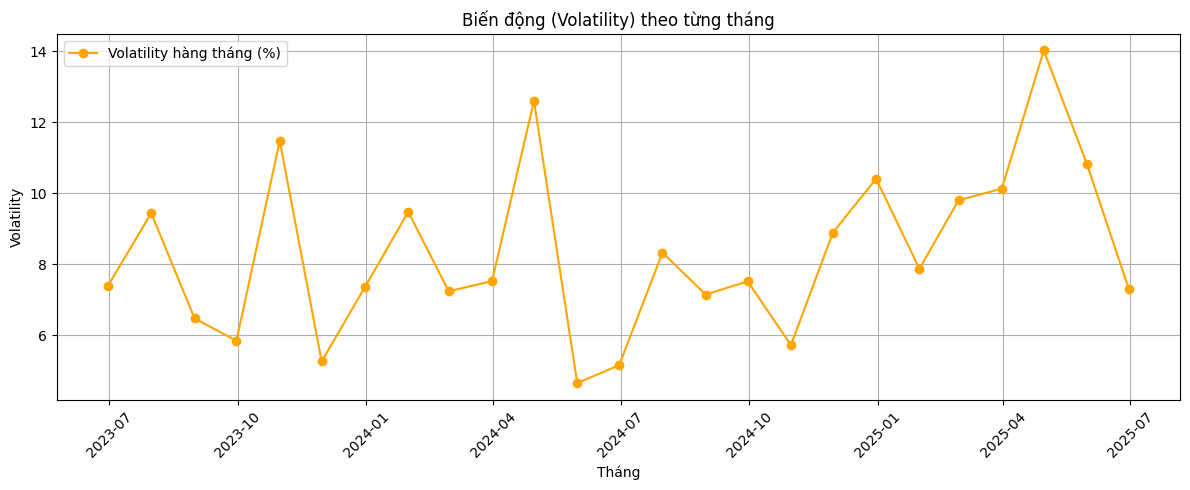

In [11]:
import matplotlib.pyplot as plt
# Tính_volatility theo tháng 
monthly_volatility=Data['daily_return'].resample('ME').std()*np.sqrt(21)
monthly_volatility_percentage=monthly_volatility*100
plt.figure(figsize=(12, 5))
plt.plot(monthly_volatility_percentage, marker='o', linestyle='-', color='orange', label='Volatility hàng tháng (%)')
plt.title("Biến động (Volatility) theo từng tháng")
plt.xlabel("Tháng")
plt.ylabel("Volatility")
plt.xticks(rotation=45)
plt.grid(True)  
plt.legend()
plt.tight_layout()
plt.show()


- Nhìn chung, mã cổ phiếu GG thể hiện mức độ biến động (volatility) cao, với giá trị thường xuyên vượt ngưỡng 5%. Đây là đặc điểm điển hình của nhóm cổ phiếu công nghệ, phản ánh mức độ rủi ro cao đối với nhà đầu tư. Điều này gây rắc rối với nhà đầu tư dài hạn nhưng được coi như cơ hội với những nhà đầu tư ngắn hạn. 

- Đáng chú ý, độ biến động này tăng mạnh trong tháng 5/2025 ở mức 14%, trùng với giai đoạn có nhiều biến động lớn trên thị trường tài chính toàn cầu, chủ yếu bắt nguồn từ việc ông Donald Trump tái đắc cử Tổng thống Mỹ và công bố hàng loạt chính sách kinh tế gây tranh cãi.

#### Histogram lợi suất

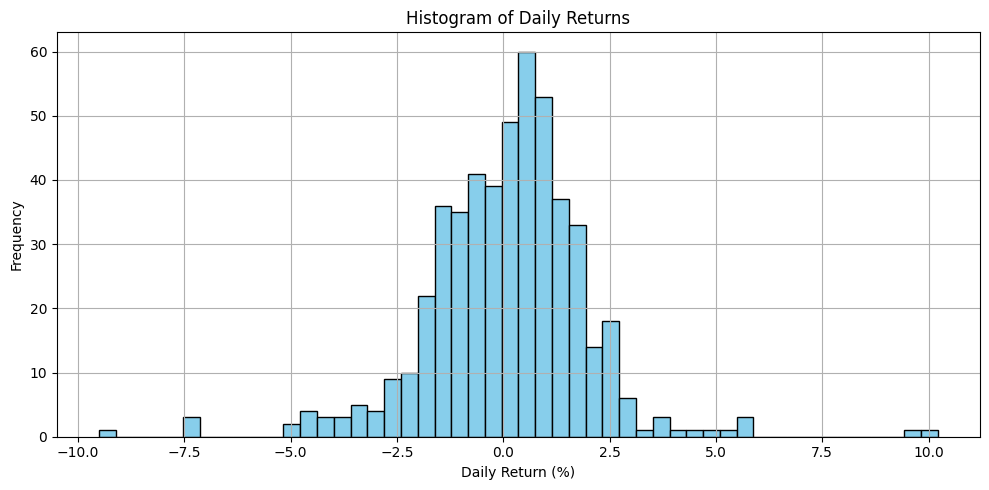

In [12]:
# Code biểu đồ Histogram lợi suất
plt.figure(figsize=(10, 5))
daily_return_percentage = Data['daily_return'].dropna()*100
plt.hist(daily_return_percentage, bins=50, color='skyblue', edgecolor='black')
plt.title('Histogram of Daily Returns')
plt.xlabel('Daily Return (%)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

- Phần lớn lợi suất tập trung quanh giá trị trung tâm, cho thấy phân phối gần như đối xứng (dạng gần chuẩn). Điều này phản ánh rằng đa số các phiên giao dịch có mức biến động nhỏ và nằm trong khoảng ổn định.

- Tuy nhiên, vẫn xuất hiện một số giá trị lợi suất cực trị ở cả hai phía: phía trái ghi nhận một số phiên giảm mạnh với mức lỗ lên tới khoảng 7% và 9%, trong khi phía phải có hai phiên tăng đột biến với lợi suất xấp xỉ 10%. Những điểm cực trị này phản ánh rủi ro thị trường vẫn tồn tại và cần được lưu ý trong quá trình đánh giá hiệu suất đầu tư


#### Tương quan giá đóng cửa và SMA, EMA


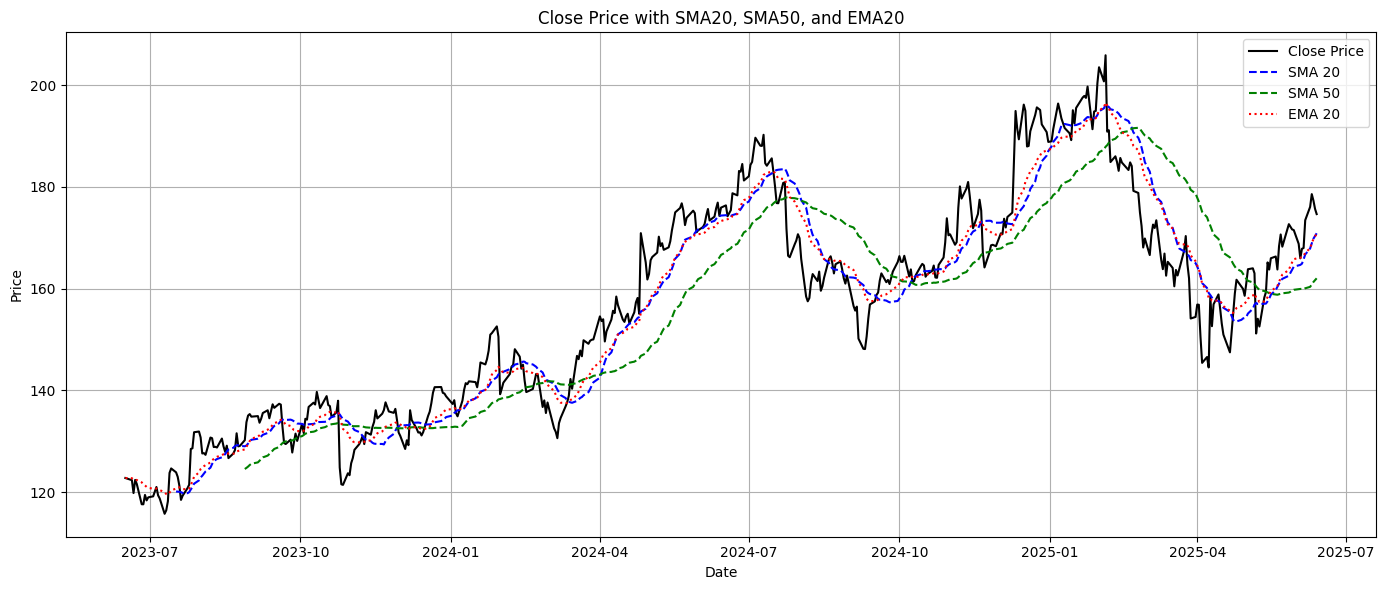

In [13]:
import seaborn as sns
# Biểu đồ giá đóng cửa kèm SMA; EMA
Data.to_csv("output.csv", index=True)
plt.figure(figsize=(14, 6))
plt.plot(Data['Close'], label='Close Price', color='black')
plt.plot(Data['SMA_20'], label='SMA 20', color='blue', linestyle='--')
plt.plot(Data['SMA_50'], label='SMA 50', color='green', linestyle='--')
plt.plot(Data['EMA_20'], label='EMA 20', color='red', linestyle=':')
plt.title('Close Price with SMA20, SMA50, and EMA20')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

##### Phân tích xu hướng
- Từ 06/2023 đến 06/2024: Xu hướng tăng mạnh, đặc biệt là từ đầu 2024 đến giữa 2024, giá cổ phiếu tăng rõ rệt. Xu hướng này là do không có cú sốc kinh tế nào tác động cùng với sự phát triển đầy hứa hẹn của AI tăng lòng tin đầu tư vào các công ty công nghệ lớn. 
- Từ 07/2024 đến đầu 2025: Biến động mạnh hơn, có sự điều chỉnh giảm sâu vào khoảng tháng 03/2025. Cụ thể tháng 8/2024: Google bị tòa xác định vi phạm luật chống độc quyền; áp lực yêu cầu tách Chrome vào đầu năm 2025 làm giá cổ phiếu hạ hơn 5-13 %. Và từ 03/2025 đến 04/2025: Giá giảm mạnh, nguyên nhân chính là do thị trường toàn cầu bất ổn do lo sợ chiến tranh thương mại và thuế quan mới, gây ra đợt “crash” ngắn hạn 
- Từ 05/2025 đến 06/2025: Có dấu hiệu phục hồi do có thỏa thuận tạm ngưng hoặc giảm bớt thuế quan giữa Mỹ và Trung Quốc, giúp xoa dịu lo ngại về ảnh hưởng tiêu cực tới doanh thu quảng cáo, mảng then chốt của Alphabet. 
##### Tín hiệu giao cắt
- Golden Cross: Khoảng cuối 2023 đến đầu 2024, SMA20 và EMA20 cắt lên SMA50 → Tín hiệu mua.
- Death Cross: Khoảng tháng 03/2025, SMA20 cắt xuống dưới SMA50 → Tín hiệu bán.


#### Heatmap tương quan

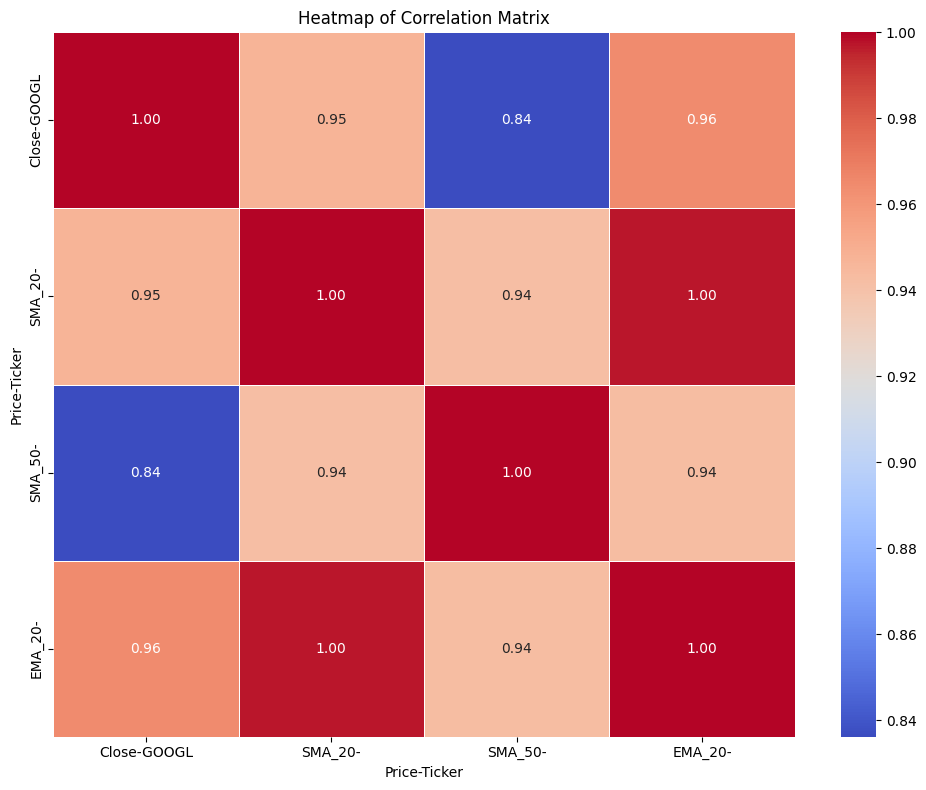

In [7]:
# heatmap ma trận tương quan 
corr_columns = ['Close', 'SMA_20', 'SMA_50', 'EMA_20']
corr_matrix = Data[corr_columns].corr()
# Vẽ heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap of Correlation Matrix')
plt.tight_layout()
plt.show()

- Các chỉ báo kỹ thuật như SMA và EMA đều cho thấy mối tương quan mạnh với giá đóng cửa, cho thấy tính đồng biến giữa các đường trung bình động và xu hướng giá.

- Đặc biệt, chỉ báo EMA_20 có hệ số tương quan cao nhất với giá đóng cửa, phản ánh khả năng bám sát biến động ngắn hạn tốt hơn so với các đường trung bình khác, nhờ ưu thế phản ứng nhanh với các thay đổi trong dữ liệu giá.



# 🗒️ 5.Nhận xét
### Xu hướng chính: 
- Từ 06/2023 đến 06/2024: Cổ phiếu GOOGL trong xu hướng tăng trưởng ổn định, giá liên tục vượt lên các đường trung bình SMA20, EMA20 và SMA50. Đây là giai đoạn tích lũy và tăng giá mạnh của cổ phiếu.
- Từ 07/2024 đến 03/2025: Bắt đầu xuất hiện biến động mạnh, xu hướng điều chỉnh rõ rệt. Giá có nhiều lần gãy dưới các đường trung bình, đặc biệt là đợt giảm mạnh vào đầu năm 2025. 
- Từ 04/2025 đến 06/2025: Cổ phiếu có dấu hiệu phục hồi, giá bắt đầu tăng trở lại, các đường EMA20 và SMA20 đang có xu hướng cắt lên từ dưới → tín hiệu tích cực.
### Những giai đoạn biến động cao:
- Từ 07/2024 đến 03/2025: có nhiều biến động mạnh, tạo ra dao động lớn quanh SMA20 và EMA20 → thị trường có dấu hiệu thiếu ổn định. Những cú rơi này có nguồn gốc mạnh mẽ từ những cú sốc kinh tế toàn cầu và những tin tức tiêu cực của riêng Alphabet Inc, công ty mẹ sở hữu Google.
- Tháng 3/2025 đỉnh điểm khi giá rơi xuống thấp hơn cả 3 đường trung bình, cộng với sự giao cắt thường xuyên cho thấy biến động cao và rủi ro lớn.
### Khuyến nghị đầu tư cơ bản:
- Với nhà đầu tư dài hạn: Dựa vào xu hướng tăng ổn định trong 2 tháng gần đây, kết hợp với tín hiệu tốt từ EMA_20 cổ phiếu GOOGL được khuyến nghị **Mua (Buy)** .
- Với nhà đầu tư ngắn hạn: Mặc dù có tín hiệu phục hồi, thị trường hiện tiềm ẩn rủi ro cao do biến động mạnh (dựa trên chỉ số volatility), tuy có thể coi là một cơ hội đầu từ nhưng vần cần quan sát các chỉ số cẩn trọng và chưa nên giải ngân mạnh trong giai đoạn hiện tại.

# ✅ 6.Kết luận
- Cổ phiếu GOOGL thể hiện đặc trưng của nhóm công nghệ: tốc độ tăng trưởng cao đi kèm với mức độ biến động lớn.
- Dù tồn tại một số rủi ro ngắn hạn, GOOGL vẫn là một lựa chọn tiềm năng cho chiến lược đầu tư dài hạn. 
- Nhà đầu tư cần thường xuyên theo dõi các sự kiện và tin tức có ảnh hưởng đến doanh nghiệp để đưa ra quyết định kịp thời và hiệu quả.

## Các nguồn tham khảo
- Z-score: https://www.geeksforgeeks.org/data-science/detect-and-remove-the-outliers-using-python/
- SMA, RSI: https://www.quantifiedstrategies.com/relative-strength-index-and-moving-average-trading-strategy/ 
- EMA: https://stackoverflow.com/questions/76317946/calculate-exponential-moving-average-using-pandas-dataframe
- Nhận xét về rủi ro theo volatility: https://www.investopedia.com/terms/v/volatility.asp
- Tín hiệu giao cắt: https://www.investopedia.com/articles/active-trading/052014/how-use-moving-average-buy-stocks.asp
- Phân tích histogram: https://www.financestrategists.com/wealth-management/fundamental-vs-technical-analysis/histograms/
- Công cụ dịch và kiểm tra chính tả: GG dịch, chat GPT.